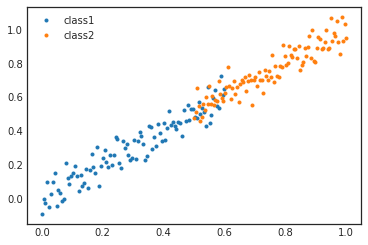

In [193]:
import numpy as np
import matplotlib.pyplot as plt

def f(x,m,c):
    return m*x + c

x1=np.linspace(0,0.6,100)
y1=f(x1+np.random.normal(0,0.06,100),1,0)

x2=np.linspace(0.5,1,100)
y2=f(x2+np.random.normal(0,0.06,100),1,0)

plt.plot(x1,y1,'.',label='class1') # class 1
plt.plot(x2,y2,'.',label='class2') # class 2
plt.legend()
plt.show()

In [194]:
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale


%matplotlib inline

import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons



In [196]:


Y1=np.zeros(100)
Y2=np.ones(100)
Y=np.concatenate((Y1, Y2), axis=0)
Y.shape

x=np.concatenate((x1, x2), axis=0)
y=np.concatenate((y1, y2), axis=0)

X=np.stack((x, y), axis=-1)
X.shape , Y.shape

X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)


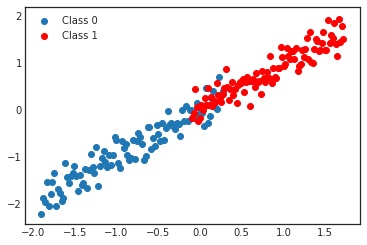

In [201]:
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
plt.legend()
plt.show()

